In [1]:
import sklearn
import sklearn.gaussian_process
reload(sklearn.gaussian_process)
sklearn.__file__

'/Users/davidcottrell/dev/scikit-learn.git/sklearn/__init__.py'

In [2]:
def load_data():
    import sklearn.datasets as datasets
    d = datasets.load_iris()
    c = pandas.Categorical.from_codes(d.target, d.target_names)
    df = pandas.DataFrame(d.data, columns=d.feature_names)
    df['name'] = c
    df = df.sort_index(axis=1)
    dfd = pandas.get_dummies(df)
    return df, dfd

df, dfd = load_data()
print(dfd.shape)
dfd.head()

(150, 7)


,petal length (cm),petal width (cm),sepal length (cm),sepal width (cm),name_setosa,name_versicolor,name_virginica
0,1.4,0.2,5.1,3.5,1,0,0
1,1.4,0.2,4.9,3.0,1,0,0
2,1.3,0.2,4.7,3.2,1,0,0
3,1.5,0.2,4.6,3.1,1,0,0
4,1.4,0.2,5.0,3.6,1,0,0


/Users/davidcottrell/anaconda/envs/py35/lib/python3.5/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))
/Users/davidcottrell/anaconda/envs/py35/lib/python3.5/site-packages/matplotlib/__init__.py:892: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


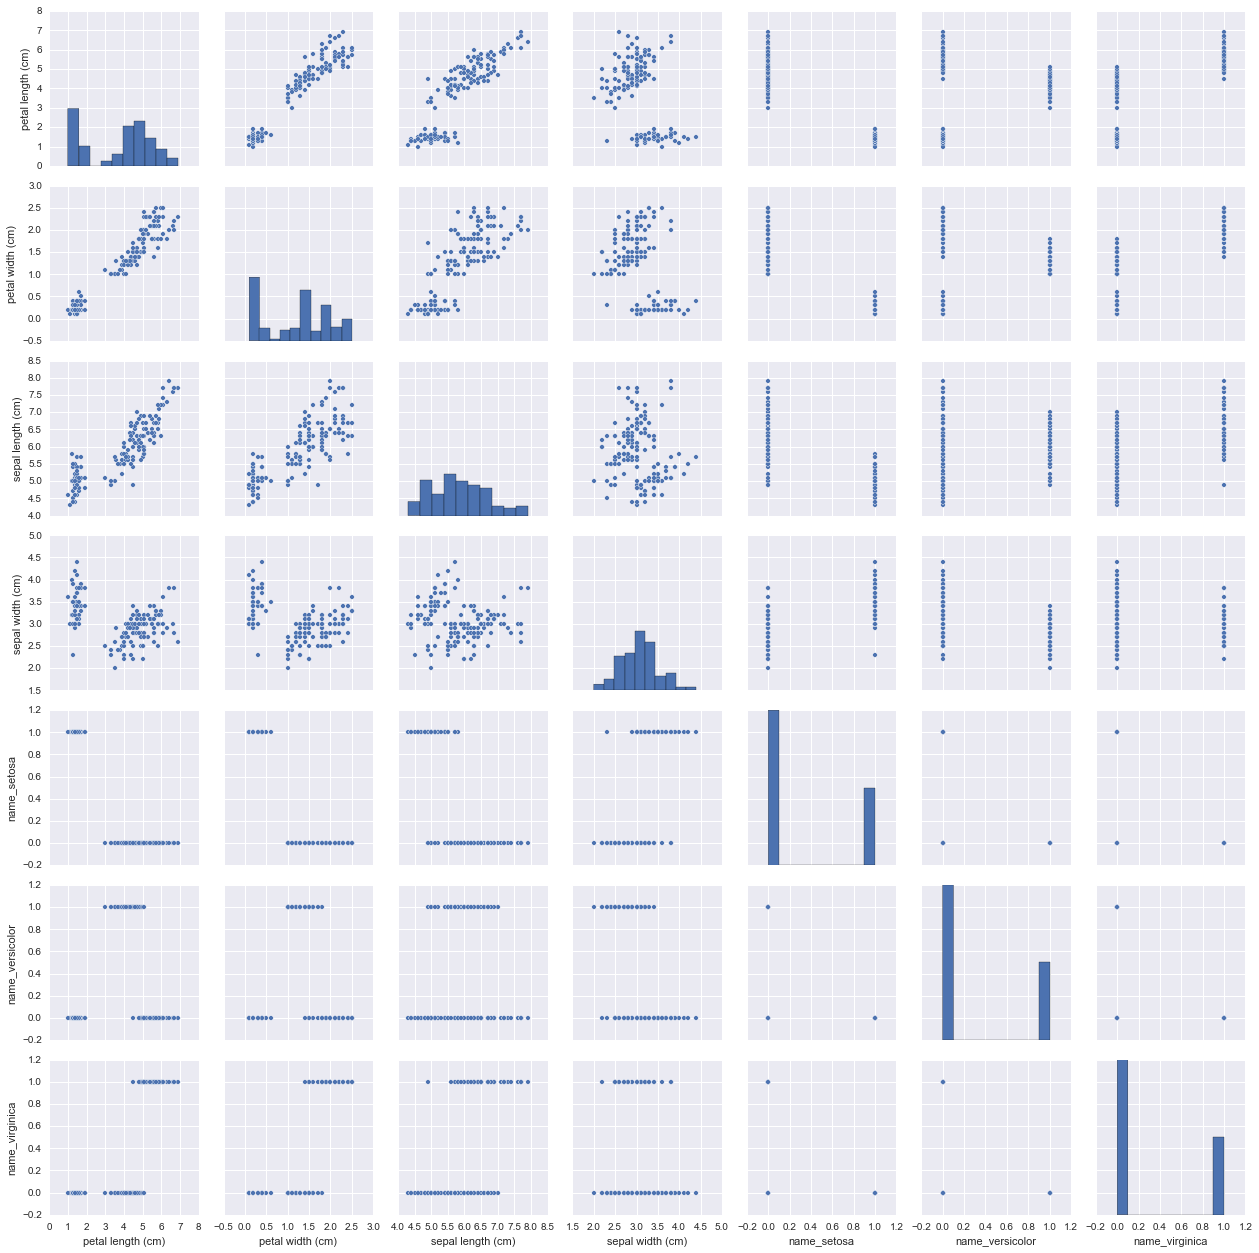

In [3]:
%matplotlib inline
import seaborn as sns
sns.pairplot(dfd)
show()

# Simple 1d X examples

(120, 1) (120,) (30, 1) (30,)


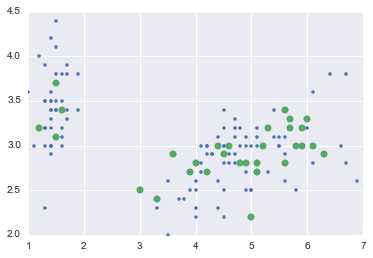

In [14]:
%matplotlib inline
kx = dfd.columns[0]
ky = dfd.columns[3]
x = df[kx].values
X = np.atleast_2d(x).T
y = df[ky].values

import sklearn.cross_validation as cv
X, Xtest, y, ytest = cv.train_test_split(X, y, test_size=0.2)
x = X.squeeze()

print(X.shape, y.shape, Xtest.shape, ytest.shape)

plot(x, y, '.')
plot(Xtest[:,0], ytest, 'o')
show()

# GP

In [5]:
import numpy as np

class GP:
    """ (n, d)-array xtrain and an n-vector ytrain """
    def __init__(self, kernel, sigma=1.0):
        self.kernel = kernel
        self.sigma = sigma
        self.predict = self.posterior
        self.fit = self.add_data
        
    def add_data(self, xtrain, ytrain):
        """ append data, update mu and K """
        self.xtrain = xtrain # hstack(self.xtrain, xtrain)
        self.ytrain = ytrain # hstack(self.ytrain, ytrain)
        self.K = self.kernel(self.xtrain, self.xtrain)
        self.Ky = self.K + self.sigma ** 2 * eye(self.K.shape[0])
        
    def posterior(self, xtest):
        """ compute mu_star, K_star, sigma_star """
        Ks = self.kernel(self.xtrain, xtest)
        Kss = self.kernel(xtest, xtest)
        
        Kyinv = inv(self.Ky)
        KKyT = dot(Ks.T, Kyinv)
        
        mu = dot(KKyT, self.ytrain)
        Ss = Kss - dot(KKyT, Ks) 
        return mu, Ss
    
myGP = GP
    
import scipy.spatial.distance as dist

def sqexp_kernel(x1, x2, ell=.5, sf2=1.0):
    """ x1 and x2 of size (n, d) and (m, d) """
    d = dist.cdist(x1, x2, 'sqeuclidean')
    k = sf2 * exp(-0.5 * d / ell)
    return k

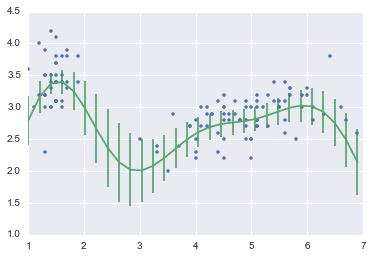

In [6]:
gp = GP(sqexp_kernel, sigma=1)
gp.add_data(X, y)
xx = np.atleast_2d(linspace(x.min(), x.max(), 30)).T
yy = np.atleast_2d(linspace(y.min(), y.max(), 30)).T
yp, s2 = gp.posterior(xx)

plot(x, y, '.')
errorbar(xx.squeeze(), yp, yerr=np.sqrt(np.diag(s2)))
show()

/Users/davidcottrell/dev/scikit-learn.git/sklearn/utils/deprecation.py:52: DeprecationWarning: Class GaussianProcess is deprecated; GaussianProcess is deprecated and will be removed in 0.20. Use the GaussianProcessRegressor instead.
  warnings.warn(msg, category=DeprecationWarning)
/Users/davidcottrell/dev/scikit-learn.git/sklearn/utils/deprecation.py:70: DeprecationWarning: Function l1_cross_distances is deprecated; l1_cross_distances is deprecated and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


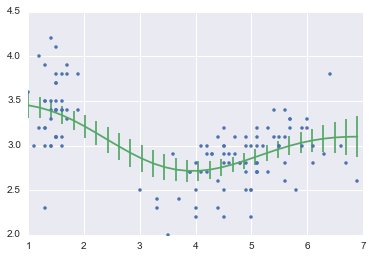

In [7]:
import sklearn.gaussian_process as gaussian_process

GP = gaussian_process.GaussianProcess(corr='squared_exponential', nugget=2, theta0=0.01, thetaL=1e-4, thetaU=0.5)

GP.fit(X, y)

ypb, s2b = GP.predict(xx, eval_MSE=True)

plot(x, y, '.')
errorbar(xx.squeeze(), ypb, yerr=1.96 * np.sqrt(s2b))
show()

# RF

<Container object of 3 artists>

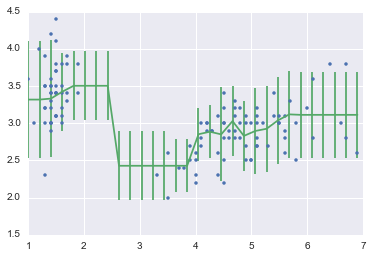

In [15]:
import sklearn.ensemble as se

def trainmodel(estimator_mean, estimator_var, X, y):
    i = 0
    e = estimator_mean
    e2 = estimator_var
    sample_weights = None; ss=None
    while i<3:
        e.fit(X, y, sample_weight=sample_weights)
        yp = e.predict(X)
        yy = (y - yp) ** 2
        e2.fit(X, yy, sample_weight=None)
        yyp = e.predict(X)
        sample_weights = 1 / np.sqrt(yyp)
        ss = 1 / sample_weights
        i = i + 1
    return e, e2

params = dict(n_estimators=100, min_samples_leaf=10)
params2 = params.copy()
params2['min_samples_leaf'] = 30
e = se.GradientBoostingRegressor(**params)
e2 = se.GradientBoostingRegressor(**params2)
trainmodel(e, e2, X, y)
yp = e.predict(xx)
yyp = e2.predict(xx)
plot(X[:,0], y, '.')
errorbar(xx[:,0], yp, yerr=1.96 * np.sqrt(yyp))

## quantile loss
http://scikit-learn.org/stable/auto_examples/ensemble/plot_gradient_boosting_quantile.html

http://scikit-learn.org/stable/modules/ensemble.html#regression

To use other weak learnings see: http://stackoverflow.com/questions/17454139/gradientboostingclassifier-with-a-baseestimator-in-scikit-learn

(30,)
(30,)
(30,)


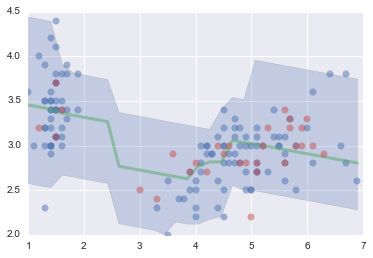

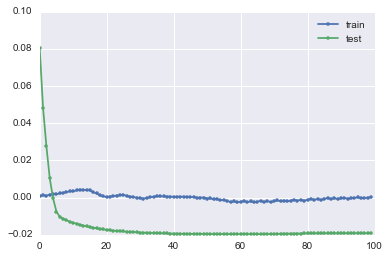

In [18]:
import sklearn.linear_model as lm
est_class = se.GradientBoostingRegressor

class init:
    def __init__(self, est):
        self.est = est
    def predict(self, X):
        return np.atleast_2d(self.est.predict(X)).T
    def fit(self, X, y, samples_weights):
        self.est.fit(X, y)

init_here = init(lm.LinearRegression())
# init_here = init(se.RandomForestRegressor(min_samples_leaf=100))
        
e = est_class(loss='quantile', n_estimators=100, min_samples_leaf=30, init=init_here)
yp = []
for i, p in enumerate([0.025, 0.5, 0.975]):
    e.set_params(alpha=p)
    e.fit(X, y)
    yp.append( e.predict(xx))
    print(yp[-1].shape)
    
fill_between(xx.squeeze(), yp[0], yp[2], alpha=0.25)
plot(X[:,0], y, 'o', alpha=0.5)
plot(xx, yp[1], alpha=0.5, linewidth=3)
plot(Xtest[:,0], ytest, 'o', alpha=0.5)

score = []
for yp_ in e.staged_predict(Xtest):
    score.append(e.loss_(ytest, yp_))
    

e.set_params(alpha=0.5, loss='quantile')
e.fit(X, y)
figure()
plot(e.train_score_, '.-', label='train')
plot(score, '.-', label='test')
legend()

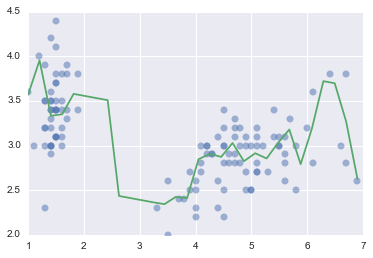

In [19]:
init_here = init(lm.LinearRegression())
figure()
e = est_class(loss='ls', n_estimators=100, init=init_here)
e.fit(X, y)
yp = e.predict(xx)
plot(X[:,0], y, 'o', alpha=0.5)
plot(xx, yp)

# GMM

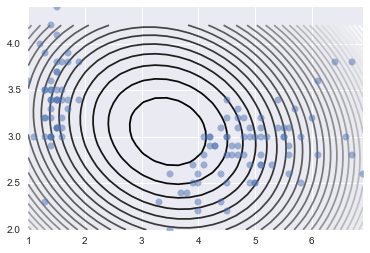

In [20]:
import sklearn.mixture as sm
e = sm.DPGMM(covariance_type='tied')
A = np.concatenate([X, np.atleast_2d(y).T], axis=1)
e.fit(A)

XX, YY = meshgrid(xx, yy)
XY = np.vstack([XX.ravel(), YY.ravel()]).T
PP = e.score(XY)
PP = PP.reshape(-1, 30)

plot(X.squeeze(), y.squeeze(), 'o', alpha=0.5)
contour(XX, YY, PP, 30)

# GMM network
https://github.com/fchollet/keras/issues/1061

# Random Trees Embedding

(120, 4) (120,) (30, 4) (30,)


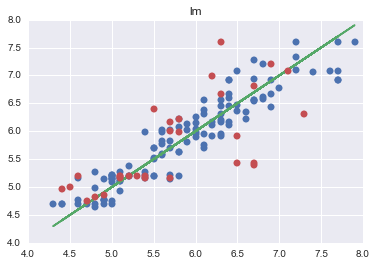

In [79]:
ky = df.columns[3]
kx = [x for x in df.columns if x != ky]
X = df[kx].copy()
X['name'] = X['name'].cat.codes
X = X.values
y = df[ky]

import sklearn.cross_validation as cv
X, Xtest, y, ytest = cv.train_test_split(X, y, test_size=0.2)
x = X.squeeze()

print(X.shape, y.shape, Xtest.shape, ytest.shape)

import sklearn.ensemble as se
e = se.RandomTreesEmbedding(n_estimators=100, min_samples_leaf=20)
Xt = e.fit_transform(X)

import sklearn.linear_model as lm
ee = lm.LinearRegression()
ee.fit(Xt, y)
yp = ee.predict(Xt)

plot(y, yp, 'o')
plot(y, y, '-')

Xtestt = e.transform(Xtest)
ypt = ee.predict(Xtestt)
plot(ytest, ypt, 'o')
title('lm')

(120, 6) (120,) (30, 6) (30,)


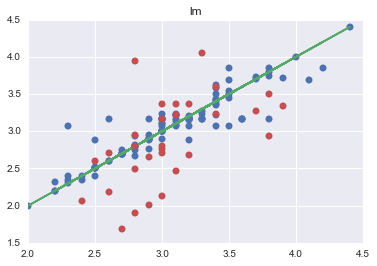

In [83]:
ky = dfd.columns[3]
kx = [x for x in dfd.columns if x != ky]
X = dfd[kx].values
y = df[ky]

import sklearn.cross_validation as cv
X, Xtest, y, ytest = cv.train_test_split(X, y, test_size=0.2)
x = X.squeeze()

print(X.shape, y.shape, Xtest.shape, ytest.shape)

import sklearn.ensemble as se
e = se.RandomTreesEmbedding(n_estimators=1000, min_samples_leaf=20)
Xt = e.fit_transform(X)

import sklearn.linear_model as lm
ee = lm.LinearRegression()
ee.fit(Xt, y)
yp = ee.predict(Xt)

plot(y, yp, 'o')
plot(y, y, '-')

Xtestt = e.transform(Xtest)
ypt = ee.predict(Xtestt)
plot(ytest, ypt, 'o')
title('lm')